# Import package and initialize model

In [1]:
from branch_calm_net.models import *

DEVICE = torch.device('cpu')

# GROUPING DECLARATION
subject_group = { # map: ID_# -> group_id
    "ID_0": '0',
    "ID_1": '1',
    "ID_2": '2'
}

# MODEL CONFIGURATION and TRAINING PARAMETERS
config = {
    'model_params': {
        'device': DEVICE,
        'in_size': 14,
        'AE': 'lstm', 
        'AE_num_layers': 1,
        'AE_hidden_size': 128,
        'covariate_size': 4, # number of covariates
        'shared_in_size': 128, # init bottleneck size
        'shared_hidden_size': 256,
        'num_branches': 5, # when equal to 1, it is equivalent to CALM_Net
        'groups': subject_group,
        'heads_hidden_size': 64,
        'num_classes': 3
    },
    'training_params': {
        'device': DEVICE, 
        'loss_weight': {
            'alpha': 1e-4,
            'beta': 1,
            'theta': 1 / 22, # 1 over number of students
        },
        'class_weights': [0.6456, 0.5635, 1.0000],
        # 'class_weights': [0.6456, 0.5635+1.0000],
        'global_lr': 1e-5,
        'branching_lr': 1e-5,
        'weight_decay': 1e-4,
        'epochs': 50, 
        'batch_size': 4,
        'use_histogram': True,
        'use_covariates': True, 
        'use_decoder': True,
    }
}

# CONSTUCT MODEL
model = MultitaskAutoencoder(config['model_params'], use_covariates=True).to(DEVICE)
model.eval()

MultitaskAutoencoder(
  (autoencoder): autoencoder(
    (encoder): LSTM(14, 128, batch_first=True)
    (encoder_act): ReLU()
    (decoder): LSTM(128, 14, batch_first=True)
    (decoder_act): Sigmoid()
  )
  (branching): branching(
    (probabilities): ParameterDict(
        (0): Parameter containing: [torch.FloatTensor of size 5]
        (1): Parameter containing: [torch.FloatTensor of size 5]
        (2): Parameter containing: [torch.FloatTensor of size 5]
    )
  )
  (branch_layer): branch_layer(
    (branches): ModuleDict(
      (0): Sequential(
        (0): Linear(in_features=132, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=132, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
        (3): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=132, ou

# Example Format of Input and Prediction Output

In [2]:
# GENERATE RANDOM EXAMPLE DATA
sample_x = torch.rand(3, 24, 8).to(DEVICE) # N, L, D
sample_ids = ['1', '0', '2']
sample_cov = torch.rand(3, 4).to(DEVICE) # N, E_c

# FORWARD PASS
final_out, AE_out = model(sample_x, sample_ids, covariate_data=sample_cov)

# print
print("Input Size:", sample_x.shape)
print("Covariates Size:", sample_cov.shape)
print("Prediction Output Size:", final_out.shape)
print("Decoder Output Size:", AE_out.shape)

Input Size: torch.Size([3, 24, 8])
Covariates Size: torch.Size([3, 4])
Prediction Output Size: torch.Size([3, 3])
Decoder Output Size: torch.Size([3, 24, 14])


# Train the model on your data

In [1]:
from branch_calm_net.models import *
from branch_calm_net.utils import *

# basic info
all_fns = os.listdir('samples')
sub_ids = list(set([s.split('_')[0] for s in all_fns]))

# fetch example data
sample_x, sample_y, sample_ids, sample_cov = get_samples(sub_ids, example_idx=np.arange(10))
val_x, val_y, val_ids_, val_cov = get_samples(sub_ids, example_idx=[-1])

# logs
print("\nTrain X Shape:", sample_x.shape, "(Batch_size, Sequence_length, Channels)")
print("Train y Shape:", sample_y.shape)
print("Train covariates Shape:", sample_cov.shape, '\n')
print("Val X Shape:", val_x.shape)
print("Val y Shape:", val_y.shape)
print("Val covariates Shape:", val_cov.shape)

100%|██████████| 15/15 [00:00<00:00, 495.67it/s]


Train X Shape: torch.Size([450, 240, 14]) (Batch_size, Sequence_length, Channels)
Train y Shape: torch.Size([450])
Train covariates Shape: torch.Size([450, 4]) 

Val X Shape: torch.Size([45, 240, 14])
Val y Shape: torch.Size([45])
Val covariates Shape: torch.Size([45, 4])


100%|██████████| 30/30 [01:16<00:00,  2.55s/it]


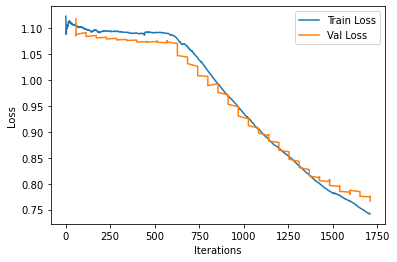

In [2]:
# for demo reproducibility
torch.manual_seed(42)
np.random.seed(42)

# construct group
subject_group = dict() # map: ID_# -> group_id
for i in range(len(sub_ids)):
    subject_group["ID_{}".format(sub_ids[i])] = str(i)

# overwrite the configuration based on the data
DEVICE = torch.device('cpu')
config = get_default_config(DEVICE)
config['model_params']['groups'] = subject_group
config['model_params']['in_size'] = 14 # number of channels
config['model_params']['num_branches'] = 3 # number of dynamic branches
config['model_params']['covariate_size'] = 4 # number of covariates

# training hyperparameters
lr = 5e-3 # 1e-3
config['training_params']['global_lr'] = lr
config['training_params']['branching_lr'] = lr
config['training_params']['weight_decay'] = 1e-6
config['training_params']['epochs'] = 30 # 50
config['training_params']['batch_size'] = 8 # 8

# construct model
model = MultitaskAutoencoder(config['model_params'], use_covariates=True).to(DEVICE)

# fit function
train_loss, train_it, val_loss, val_it = model.fit(
    config,
    sample_x.to(DEVICE),
    sample_y.to(DEVICE),
    sample_ids,
    sample_cov=sample_cov.to(DEVICE),
    val_x=val_x.to(DEVICE),
    val_y=val_y.to(DEVICE),
    val_ids=val_ids_,
    val_cov=val_cov.to(DEVICE),
    loss_mov_avg=True
)

# logs
plt.plot(train_it, train_loss, label="Train Loss")
plt.plot(val_it, val_loss, label="Val Loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Inspect the trained results of Branching/Grouping

In [3]:
# get branching records
branches = model.record_branch(return_only=True)

# fetch probability distribution
groups = dict() # map: group_id -> list(subject ids)
for id_ in branches:
    last_prob = branches[id_][-1]
    chosen_group = np.argmax(last_prob)
    if groups.get(chosen_group) is None:
        groups[chosen_group] = list()
    groups[chosen_group].append(id_)

# sort by group id
sorted_groups_items = sorted(groups.items(), key=lambda x: int(x[0]))
groups = dict()
for k, v in sorted_groups_items:
    groups[k] = v

# logs
for group_id in groups:
    print("Group {}: {}\n".format(group_id, groups[group_id]))

Group 0: ['2']

Group 1: ['12', '3', '5', '7', '9']

Group 2: ['0', '1', '10', '11', '13', '14', '4', '6', '8']



Max: 0.3525568679517696 Min: 0.32048399128877075


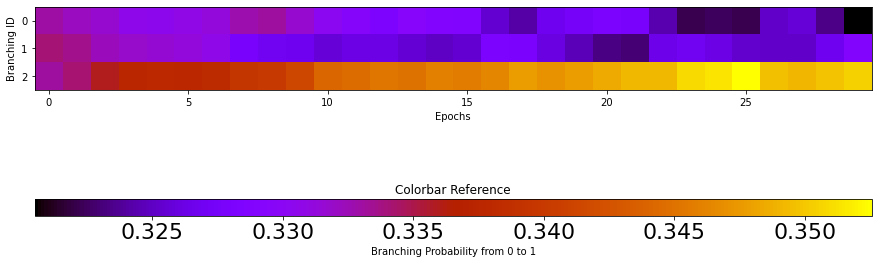

In [6]:
check_branch_evolve(model, sub_ind="1", tau=1e1, step_size=1, cmap='gnuplot')

# Demo student stress prediction from our trained model

In [31]:
from branch_calm_net.models import *
from branch_calm_net.utils import *

# load model and pretrained weight
with open('data/one_for_each.pkl', 'rb') as f:
    student_groups = pickle.load(f)

DEVICE = torch.device('cpu')
config = get_default_config(DEVICE)
config['model_params']['groups'] = student_groups
config['model_params']['in_size'] = 9 # number of channels
config['model_params']['covariate_size'] = 4 # number of covariates

model = MultitaskAutoencoder(config['model_params'], use_covariates=True).to(DEVICE)
saved_stat = torch.load('data/final_checkpoint_0.pt')
model.load_state_dict(saved_stat)
print("Checkpoint load success.")
# model

# TODO: load one day data of a student
with open('data/demo_8_5_1_9.pkl', 'rb') as f:
    demo_data = pickle.load(f)
sample_x = demo_data['histogram_data'].unsqueeze(0)
# sample_ids = [student_groups['student_8']]
sample_ids = ['8']
sample_cov = demo_data['covariate_data'].unsqueeze(0)

# make prediction
final_out, _ = model(sample_x, sample_ids, covariate_data=sample_cov)
label_to_str = {0: "Low", 1: "Medium", 2: "High"}
stress_level = torch.argmax(final_out[0]).item()
print("Given this day of data, this student is likely to have {} level of stress.".format(label_to_str[stress_level]))

Checkpoint load success.
Given this day of data, this student is likely to have High level of stress.
